# Query translations

In [8]:
# # ugly raw HTML
# import requests
# test_url = 'https://translate.google.com/?sl=it&tl=en&text=la%20sposa&op=translate'
# test_response = requests.get(test_url)
# print(test_response)
from googletrans import Translator
translator = Translator()
test_query = "l'uomo ha baciato suo marito"
test_lang = 'it'
test_query_trans = translator.translate(test_query, dest='en', src='it')
print(test_query_trans)

Translated(src=it, dest=en, text=The man kissed her husband, pronunciation=None, extra_data="{'confiden...")


### Query translations: POSSESSIVE
In which we test the tendency of the ML system to assume that `MALE` subjects cannot have `MALE` relationship targets, e.g. P("his boyfriend" | "the man kissed") < P("his girlfriend" | "the man kissed").

Let's build the queries:

X ACTION PRONOUN Y

In [52]:
import re
from unidecode import unidecode
VOWEL_MATCHER = re.compile('^[aeiou].+')
def build_sentence(lang, subject_word, sentence, article_pronoun_lookup, poss_pronoun_lookup, relationship_word_gender, relationship_word):
    poss_pronoun = poss_pronoun_lookup[relationship_word_gender]
    subject_word_pronoun = article_pronoun_lookup[relationship_word_gender]
    # clean up pronouns: catch vowels
    clean_subject_word = unidecode(subject_word)
    if(VOWEL_MATCHER.match(clean_subject_word)):
        if(lang == 'fr' or lang=='it'):
            subject_word_pronoun = "l'"
    clean_relationship_word = unidecode(relationship_word)
    if(VOWEL_MATCHER.match(clean_relationship_word)):
        if(lang == 'fr'):
            poss_pronoun = "son"
    # add extra space for pronoun
    if(subject_word_pronoun != "l'"):
        subject_word_pronoun += ' '
    subject_word_NP = f'{subject_word_pronoun}{subject_word}'
    replacement_pairs = [
        ('X', subject_word_NP), ('PRON', poss_pronoun), ('Y', relationship_word)
    ]
    for x, y in replacement_pairs:
        sentence = sentence.replace(x,y)
    return sentence

In [38]:
import pandas as pd
occupation_words = pd.read_csv('data/multilingual_gender_occupations.tsv', sep='\t', index_col=False)
relationship_words = pd.read_csv('data/multilingual_relationship_words.tsv', sep='\t', index_col=False)
relationship_sents = pd.read_csv('data/multilingual_relationship_sentences.tsv', sep='\t', index_col=False)
langs = ['es', 'fr', 'it']
lang_art_PRON_lookup = {
    'es' : {
        'female' : 'la',
        'male' : 'el',
    },
    'fr' : {
        'female' : 'la',
        'male' : 'le',
    },
    'it' : {
        'female' : 'la',
        'male' : 'il',
    }
}
lang_POSS_PRON_lookup = {
    'es' : {
        'female' : 'su',
        'male' : 'su',
    },
    'fr' : {
        'female' : 'sa',
        'male' : 'son',
    },
    'it' : {
        'female' : 'la sua',
        'male' : 'il suo',
    }
}

In [53]:
test_sent_data = [
    ('es', 'X conoció a PRON Y en una cita.', 'hombre', 'male', 'novio'),
    ('fr', 'X a rencontré PRON Y à un rendez-vous.', 'femme', 'female', 'épouse'),
    ('it', 'X ha incontrato PRON Y ad un appuntamento.', 'avvocat', 'female', 'ragazza'),
]
for lang, test_sent, subject_word, relationship_word_gender, relationship_word in test_sent_data:
    article_pronoun_lookup = lang_art_PRON_lookup[lang]
    poss_pronoun_lookup = lang_POSS_PRON_lookup[lang]
    print(build_sentence(lang, subject_word, test_sent, article_pronoun_lookup, poss_pronoun_lookup, relationship_word_gender, relationship_word))

el hombre conoció a su novio en una cita.
la femme a rencontré son épouse à un rendez-vous.
l'avvocat ha incontrato la sua ragazza ad un appuntamento.


In [127]:
from itertools import product
langs = ['es', 'fr', 'it']
final_sentence_data = []
for lang_i in langs:
    article_pronoun_lookup_i = lang_art_PRON_lookup[lang_i]
    poss_pronoun_lookup_i = lang_POSS_PRON_lookup[lang_i]
    sents_i = relationship_sents.loc[:, f'{lang_i}_sentence'].values
    # limit to different occupations
    occupation_words_i = occupation_words[occupation_words.loc[:, f'{lang_i}_female']!=occupation_words.loc[:, f'{lang_i}_male']]
    female_occupation_words_i = occupation_words_i.loc[:, f'{lang_i}_female'].values
    male_occupation_words_i = occupation_words_i.loc[:, f'{lang_i}_male'].values
    female_relationship_words_i = relationship_words.loc[:, f'{lang_i}_female'].values
    male_relationship_words_i = relationship_words.loc[:, f'{lang_i}_male'].values
    male_occupation_relationship_combos_i = list(product(male_occupation_words_i, male_relationship_words_i))
    female_occupation_relationship_combos_i = list(product(female_occupation_words_i, female_relationship_words_i))
    for sent_j in sents_i:
        for subject_word_k, relationship_word_k in male_occupation_relationship_combos_i:
            final_sent_j = build_sentence(lang_i, subject_word_k, sent_j, article_pronoun_lookup_i, poss_pronoun_lookup_i, 'male', relationship_word_k)
            final_sentence_data.append([final_sent_j, lang_i, subject_word_k, relationship_word_k, 'male'])
        for subject_word_k, relationship_word_k in female_occupation_relationship_combos_i:
            final_sent_j = build_sentence(lang_i, subject_word_k, sent_j, article_pronoun_lookup_i, poss_pronoun_lookup_i, 'female', relationship_word_k)
            final_sentence_data.append([final_sent_j, lang_i, subject_word_k, relationship_word_k, 'female'])
final_sentence_data = pd.DataFrame(final_sentence_data, columns=['sent', 'lang', 'subject_word', 'relationship_word', 'gender'])

In [129]:
print(final_sentence_data.shape[0])
display(final_sentence_data.head())

2820


,sent,lang,subject_word,relationship_word,gender
0,el autor conoció a su novio en una cita.,es,autor,novio,male
1,el autor conoció a su prometido en una cita.,es,autor,prometido,male
2,el autor conoció a su esposo en una cita.,es,autor,esposo,male
3,el panadero conoció a su novio en una cita.,es,panadero,novio,male
4,el panadero conoció a su prometido en una cita.,es,panadero,prometido,male


In [131]:
from googletrans import Translator
translator = Translator()
test_sentence_data = final_sentence_data.iloc[5, :]
test_sentence_trans = translator.translate(test_sentence_data.loc['sent'], dest='en', src=test_sentence_data.loc['lang'])
print(test_sentence_trans.text)

The baker met her husband on an appointment.


In [135]:
from time import sleep
from tqdm import tqdm
SLEEP_TIME = 1
# final_sentence_translations = []
translator = Translator()
for idx_i, sentence_data_i in tqdm(list(final_sentence_data.iterrows())[len(final_sentence_translations):]):
    translation_i = translator.translate(sentence_data_i.loc['sent'], dest='en', src=sentence_data_i.loc['lang'])
    final_sentence_translations.append(translation_i)
    try:
        sleep(SLEEP_TIME)
    except Exception as e:
        pass

100%|██████████| 1620/1620 [47:48<00:00,  1.77s/it]


In [136]:
final_sentence_data = final_sentence_data.assign(**{
    'translation' : final_sentence_translations
})
final_sentence_data = final_sentence_data.assign(**{
    'translation_txt' : final_sentence_data.loc[:, 'translation'].apply(lambda x: x.text)
})
final_sentence_data.to_csv('data/multilingual_occupation_relationship=samegender_translations.gz', compression='gzip', sep='\t', index=False)

In [137]:
import re
def extract_subject_relationship_gender(data, relationship_words):
    ## get gender of possessive pronoun for subject + gender of relationship word
    pronoun_matcher = re.compile('his|her')
    pronoun_gender_lookup = {'his' : 'male', 'her' : 'female'}
    en_female_relationship_words = relationship_words.loc[:, 'en_female'].apply(unidecode).values.tolist()
    en_male_relationship_words = relationship_words.loc[:, 'en_male'].apply(unidecode).values.tolist()
    en_relationship_words = en_female_relationship_words + en_male_relationship_words
    relationship_word_matcher = re.compile('|'.join(en_relationship_words))
    relationship_gender_lookup = {
        x : 'male' for x in en_male_relationship_words
    }
    relationship_gender_lookup.update({x : 'female' for x in en_female_relationship_words})
    for x in data.loc[:, 'translation_txt'].values:
        try:
            relationship_gender_lookup[relationship_word_matcher.search(unidecode(x)).group(0)]
        except Exception as e:
            print(f'bad text {x}')
    #         break
    data = data.assign(**{
        'translation_subject_gender' : data.loc[:, 'translation_txt'].apply(lambda x: unidecode(x)).apply(lambda x: pronoun_gender_lookup[pronoun_matcher.search(x).group(0)] if pronoun_matcher.search(x) is not None else None),
        'translation_relationship_gender' : data.loc[:, 'translation_txt'].apply(lambda x: unidecode(x)).apply(lambda x: relationship_gender_lookup[relationship_word_matcher.search(x).group(0)] if relationship_word_matcher.search(x) is not None else None),
    })
    return data

In [138]:
final_sentence_data = extract_subject_relationship_gender(final_sentence_data, relationship_words)

bad text The engineer and his boy have a son.
bad text The worker and his boy have a son.


In [139]:
## convert subject and translation words -> en
def translate_subject_relationship_words(data, occupation_words, relationship_words):
    word_other_en_lookup = {}
    langs = ['es', 'fr', 'it']
    en_occupation_words = occupation_words.loc[:, 'en'].values.tolist()
    en_relationship_words = relationship_words.loc[:, 'en_female'].values.tolist() + relationship_words.loc[:, 'en_male'].values.tolist()
    for lang in langs:
        lang_relationship_words = relationship_words.loc[:, f'{lang}_female'].values.tolist() + relationship_words.loc[:, f'{lang}_male'].values.tolist()
        lang_occupation_words = occupation_words.loc[:, f'{lang}_female'].values.tolist() + occupation_words.loc[:, f'{lang}_male'].values.tolist()
        word_lang_en_lookup = dict(zip(lang_relationship_words, en_relationship_words))
        word_lang_en_lookup.update(dict(zip(lang_occupation_words, en_occupation_words+en_occupation_words)))
        word_other_en_lookup[lang] = word_lang_en_lookup
    data = data.assign(**{
        'subject_word_en' : data.apply(lambda x: word_other_en_lookup[x.loc['lang']][x.loc['subject_word']], axis=1),
        'relationship_word_en' : data.apply(lambda x: word_other_en_lookup[x.loc['lang']][x.loc['relationship_word']], axis=1),
    })
    return data

In [140]:
final_sentence_data = translate_subject_relationship_words(final_sentence_data, occupation_words, relationship_words)

In [144]:
print(final_sentence_data.loc[:, 'translation_relationship_gender'].value_counts())

female    1410
male      1408
Name: translation_relationship_gender, dtype: int64


In [146]:
display(final_sentence_data[final_sentence_data.loc[:, 'gender']=='female'].head(20))

,sent,lang,subject_word,relationship_word,gender,translation,translation_txt,translation_subject_gender,translation_relationship_gender,subject_word_en,relationship_word_en,subject_gender_match,relationship_gender_match
108,la autora conoció a su novia en una cita.,es,autora,novia,female,"Translated(src=es, dest=en, text=The author me...",The author met her girlfriend on an appointment.,female,female,author,girlfriend,1,1
109,la autora conoció a su prometida en una cita.,es,autora,prometida,female,"Translated(src=es, dest=en, text=The author me...",The author met her fiancée at an appointment.,female,female,author,fiancee,1,1
110,la autora conoció a su esposa en una cita.,es,autora,esposa,female,"Translated(src=es, dest=en, text=The author me...",The author met his wife at an appointment.,male,female,author,wife,0,1
111,la panadera conoció a su novia en una cita.,es,panadera,novia,female,"Translated(src=es, dest=en, text=The Baker met...",The Baker met his girlfriend on an appointment.,male,female,baker,girlfriend,0,1
112,la panadera conoció a su prometida en una cita.,es,panadera,prometida,female,"Translated(src=es, dest=en, text=The Baker met...",The Baker met his fiancée at an appointment.,male,female,baker,fiancee,0,1
113,la panadera conoció a su esposa en una cita.,es,panadera,esposa,female,"Translated(src=es, dest=en, text=The Baker met...",The Baker met his wife on an appointment.,male,female,baker,wife,0,1
114,la banquera conoció a su novia en una cita.,es,banquera,novia,female,"Translated(src=es, dest=en, text=The banquet m...",The banquet met his girlfriend on an appointment.,male,female,banker,girlfriend,0,1
115,la banquera conoció a su prometida en una cita.,es,banquera,prometida,female,"Translated(src=es, dest=en, text=The banquet m...",The banquet met his fiancée at an appointment.,male,female,banker,fiancee,0,1
116,la banquera conoció a su esposa en una cita.,es,banquera,esposa,female,"Translated(src=es, dest=en, text=The banquet m...",The banquet met his wife at an appointment.,male,female,banker,wife,0,1
117,la peluquera conoció a su novia en una cita.,es,peluquera,novia,female,"Translated(src=es, dest=en, text=The hairdress...",The hairdresse met his girlfriend on an appoin...,male,female,barber,girlfriend,0,1


What is the overall proportion of "correct" translations?

In [142]:
final_sentence_data = final_sentence_data.assign(**{
    'subject_gender_match' : (final_sentence_data.loc[:, 'gender'] == final_sentence_data.loc[:, 'translation_subject_gender']).astype(int),
    'relationship_gender_match' : (final_sentence_data.loc[:, 'gender'] == final_sentence_data.loc[:, 'translation_relationship_gender']).astype(int),
})
# limit to valid data (non-None)
valid_final_sentence_data = final_sentence_data[(final_sentence_data.loc[:, 'translation_subject_gender'].apply(lambda x: x is not None)) & 
                                                (final_sentence_data.loc[:, 'translation_relationship_gender'].apply(lambda x: x is not None))]
print(f'{valid_final_sentence_data.shape[0]/final_sentence_data.shape[0]} valid gender translation data')
## get "both match" var
valid_final_sentence_data = valid_final_sentence_data.assign(**{
    'subject_relationship_gender_match' : valid_final_sentence_data.loc[:, ['relationship_gender_match', 'subject_gender_match']].min(axis=1)
})

0.9971631205673759 valid gender translation data


In [181]:
print(valid_final_sentence_data.loc[:, 'subject_gender_match'].mean()*100)
print(valid_final_sentence_data.loc[:, 'relationship_gender_match'].mean()*100)
print(valid_final_sentence_data.groupby('gender').apply(lambda x: x.loc[:, 'subject_gender_match'].mean()))

38.477951635846374
100.0
gender
female    0.086182
male      0.682528
dtype: float64


OK! All of the translations got the relationship gender correct but messed up the subject gender quite a bit.

Let's see if this varies by language, target type or subject type.

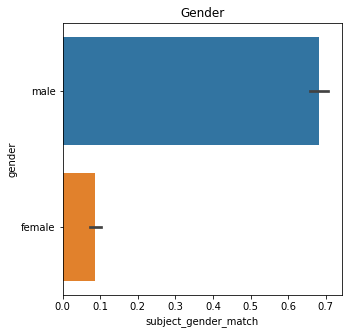

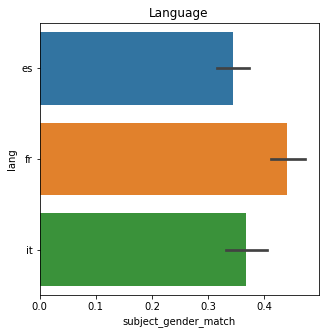

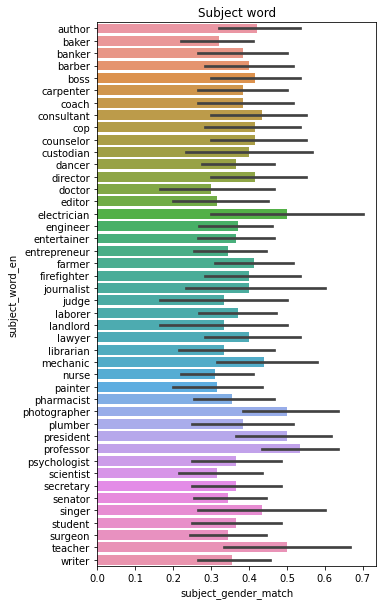

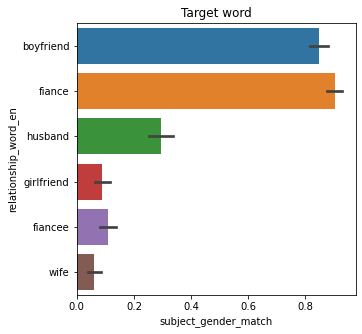

In [150]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
## gender
plt.figure(figsize=(5,5))
sns.barplot(data=valid_final_sentence_data, y='gender', x='subject_gender_match')
plt.title('Gender')
## language
plt.figure(figsize=(5,5))
sns.barplot(data=valid_final_sentence_data, y='lang', x='subject_gender_match')
plt.title('Language')
# subject word
plt.show()
plt.figure(figsize=(5, 10))
sns.barplot(data=valid_final_sentence_data, y='subject_word_en', x='subject_gender_match', order=list(sorted(valid_final_sentence_data.loc[:, 'subject_word_en'].unique())))
plt.title('Subject word')
# target word
plt.show()
plt.figure(figsize=(5,5))
sns.barplot(data=valid_final_sentence_data, y='relationship_word_en', x='subject_gender_match')
plt.title('Target word')
plt.show()

Let's also do gender on top of this.

**** gender=female ****


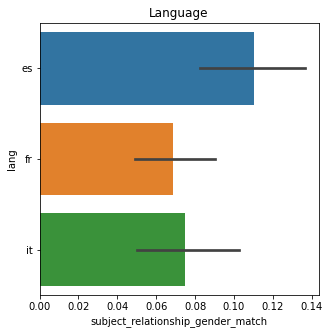

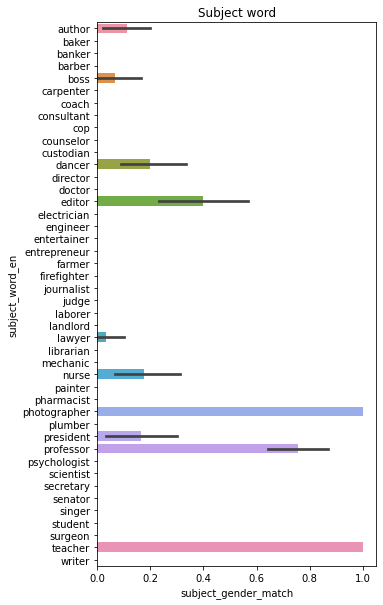

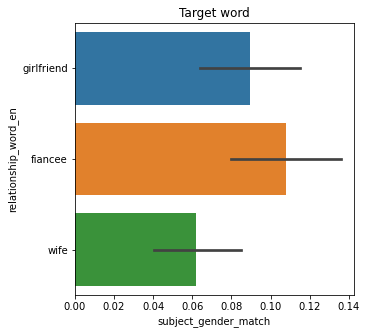

**** gender=male ****


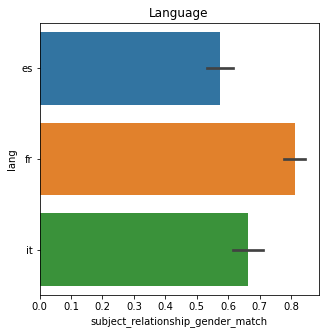

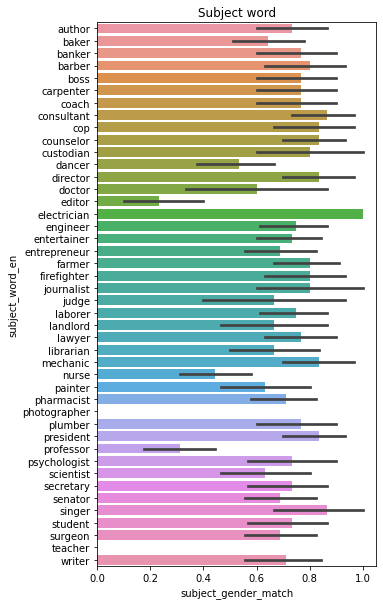

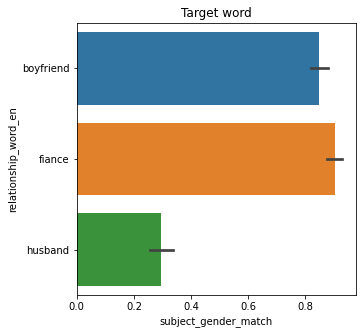

In [149]:
for gender_i, data_i in valid_final_sentence_data.groupby('gender'):
    print(f'**** gender={gender_i} ****')
    ## language
    plt.figure(figsize=(5,5))
    sns.barplot(data=data_i, y='lang', x='subject_relationship_gender_match')
    plt.title('Language')
    # subject word
    plt.show()
    plt.figure(figsize=(5, 10))
    sns.barplot(data=data_i, y='subject_word_en', x='subject_gender_match', order=list(sorted(valid_final_sentence_data.loc[:, 'subject_word_en'].unique())))
    plt.title('Subject word')
    # target word
    plt.show()
    plt.figure(figsize=(5,5))
    sns.barplot(data=data_i, y='relationship_word_en', x='subject_gender_match')
    plt.title('Target word')
    plt.show()

A lot of the poor performance can be attributed to the gender gap: the system generally tends to read female occupations as male and then translate accordingly (e.g. `his wife`).

### Translation baseline: different-gender relationships

Now! Let's repeat the experiment but use different-gender relationships as the "baseline". We need to verify that the translations are not just uniformly incorrect but specifically incorrect for same-gender relationships.

In [153]:
from itertools import product
def generate_sentence_data(relationship_sents, occupation_words, relationship_words, 
                           lang_art_PRON_lookup, lang_POSS_PRON_lookup, 
                           relationship_type='same_gender'):
    langs = ['es', 'fr', 'it']
    data = []
    for lang_i in langs:
        article_pronoun_lookup_i = lang_art_PRON_lookup[lang_i]
        poss_pronoun_lookup_i = lang_POSS_PRON_lookup[lang_i]
        sents_i = relationship_sents.loc[:, f'{lang_i}_sentence'].values
        # limit to occupation words that have different forms for female/male
        occupation_words_i = occupation_words[occupation_words.loc[:, f'{lang_i}_female']!=occupation_words.loc[:, f'{lang_i}_male']]
        female_occupation_words_i = occupation_words_i.loc[:, f'{lang_i}_female'].values
        male_occupation_words_i = occupation_words_i.loc[:, f'{lang_i}_male'].values
        female_relationship_words_i = relationship_words.loc[:, f'{lang_i}_female'].values
        male_relationship_words_i = relationship_words.loc[:, f'{lang_i}_male'].values
        if(relationship_type=='same_gender'):
            male_subject_occupation_relationship_combos_i = list(product(male_occupation_words_i, male_relationship_words_i))
            female_subject_occupation_relationship_combos_i = list(product(female_occupation_words_i, female_relationship_words_i))
        else:
            male_subject_occupation_relationship_combos_i = list(product(male_occupation_words_i, female_relationship_words_i))
            female_subject_occupation_relationship_combos_i = list(product(female_occupation_words_i, male_relationship_words_i))
        for sent_j in sents_i:
            for subject_word_k, relationship_word_k in male_subject_occupation_relationship_combos_i:
                final_sent_j = build_sentence(lang_i, subject_word_k, sent_j, article_pronoun_lookup_i, poss_pronoun_lookup_i, 'male', relationship_word_k)
                data.append([final_sent_j, lang_i, subject_word_k, relationship_word_k, 'male'])
            for subject_word_k, relationship_word_k in female_subject_occupation_relationship_combos_i:
                final_sent_j = build_sentence(lang_i, subject_word_k, sent_j, article_pronoun_lookup_i, poss_pronoun_lookup_i, 'female', relationship_word_k)
                data.append([final_sent_j, lang_i, subject_word_k, relationship_word_k, 'female'])
    data = pd.DataFrame(data, columns=['sent', 'lang', 'subject_word', 'relationship_word', 'subject_gender'])
    other_gender_lookup = {'male' : 'female', 'female' : 'male'}
    if(relationship_type=='same_gender'):
        data = data.assign(**{'relationship_gender' : data.loc[:, 'subject_gender'].values})
    else:
        data = data.assign(**{'relationship_gender' : data.loc[:, 'subject_gender'].apply(other_gender_lookup.get)})
    return data

In [154]:
diff_gender_sentence_data = generate_sentence_data(relationship_sents, occupation_words, relationship_words, 
                                                   lang_art_PRON_lookup, lang_POSS_PRON_lookup, 
                                                   relationship_type='diff_gender')
display(diff_gender_sentence_data.head())

,sent,lang,subject_word,relationship_word,subject_gender,relationship_gender
0,el autor conoció a su novia en una cita.,es,autor,novia,male,female
1,el autor conoció a su prometida en una cita.,es,autor,prometida,male,female
2,el autor conoció a su esposa en una cita.,es,autor,esposa,male,female
3,el panadero conoció a su novia en una cita.,es,panadero,novia,male,female
4,el panadero conoció a su prometida en una cita.,es,panadero,prometida,male,female


In [155]:
from time import sleep
from tqdm import tqdm
SLEEP_TIME = 1
sentence_translations = []
translator = Translator()
for idx_i, sentence_data_i in tqdm(list(diff_gender_sentence_data.iterrows())):
    translation_i = translator.translate(sentence_data_i.loc['sent'], dest='en', src=sentence_data_i.loc['lang'])
    sentence_translations.append(translation_i)
    try:
        sleep(SLEEP_TIME)
    except Exception as e:
        pass

100%|██████████| 2820/2820 [1:22:07<00:00,  1.75s/it]


In [158]:
## fix data etc.
diff_gender_sentence_data = diff_gender_sentence_data.assign(**{
    'translation' : sentence_translations
})
diff_gender_sentence_data = diff_gender_sentence_data.assign(**{
    'translation_txt' : diff_gender_sentence_data.loc[:, 'translation'].apply(lambda x: x.text)
})
diff_gender_sentence_data = extract_subject_relationship_gender(diff_gender_sentence_data, relationship_words)
diff_gender_sentence_data = translate_subject_relationship_words(diff_gender_sentence_data, occupation_words, relationship_words)
diff_gender_sentence_data.to_csv('data/multilingual_occupation_relationship=diffgender_translations.gz', compression='gzip', sep='\t', index=False)

bad text The policeman met his girl at an appointment.
bad text The ballerina met his girl at an appointment.
bad text The entertainer met his girl at an appointment.
bad text The farmer met his girl at an appointment.
bad text The worker met his girl at an appointment.
bad text The nurse met his girl at an appointment.
bad text The painter met his girl at an appointment.
bad text The scientist met his girl at an appointment.
bad text The senator met his girl at an appointment.
bad text The student met his girl at an appointment.
bad text The surgeon met his girl at an appointment.
bad text The writer met his girl at an appointment.
bad text The author and his girl have a son.
bad text The baker and his girl have a son.
bad text The policeman and his girl have a son.
bad text The ballerina and his girl have a son.
bad text The engineer and his girl have a son.
bad text The entertainer and his girl have a son.
bad text The businesswoman and his girl have a son.
bad text The farmer and h

In [177]:
## cleanup
diff_gender_sentence_data = diff_gender_sentence_data.assign(**{
    'subject_gender_match' : (diff_gender_sentence_data.loc[:, 'subject_gender'] == diff_gender_sentence_data.loc[:, 'translation_subject_gender']).astype(int),
    'relationship_gender_match' : (diff_gender_sentence_data.loc[:, 'relationship_gender'] == diff_gender_sentence_data.loc[:, 'translation_relationship_gender']).astype(int),
})
valid_diff_gender_sentence_data = diff_gender_sentence_data[(diff_gender_sentence_data.loc[:, 'translation_subject_gender'].apply(lambda x: x is not None)) & 
                                                            (diff_gender_sentence_data.loc[:, 'translation_relationship_gender'].apply(lambda x: x is not None))]

In [178]:
print(valid_diff_gender_sentence_data.loc[:, 'subject_gender_match'].mean()*100)
print(valid_diff_gender_sentence_data.loc[:, 'relationship_gender_match'].mean()*100)

65.45519971212667
100.0


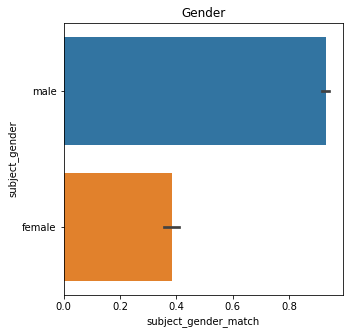

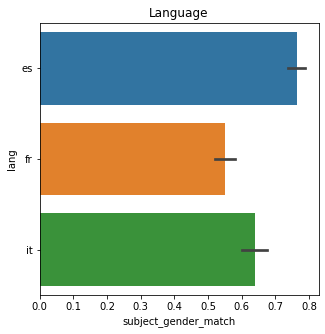

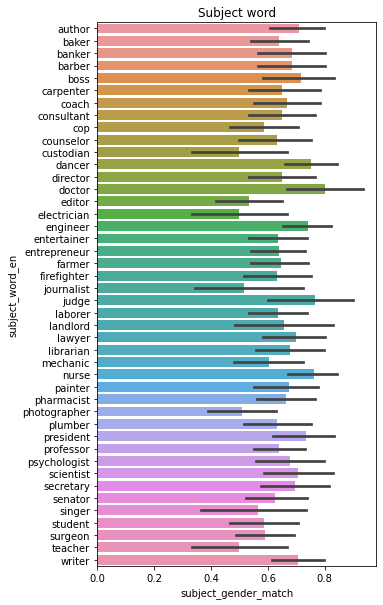

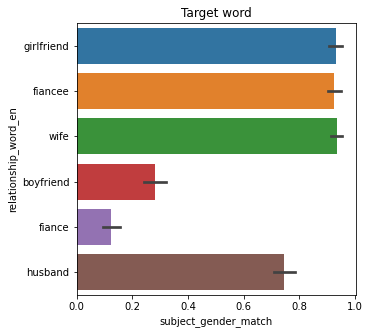

In [179]:
## show distributions 
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
## gender
plt.figure(figsize=(5,5))
sns.barplot(data=valid_diff_gender_sentence_data, y='subject_gender', x='subject_gender_match')
plt.title('Gender')
## language
plt.figure(figsize=(5,5))
sns.barplot(data=valid_diff_gender_sentence_data, y='lang', x='subject_gender_match')
plt.title('Language')
# subject word
plt.show()
plt.figure(figsize=(5, 10))
sns.barplot(data=valid_diff_gender_sentence_data, y='subject_word_en', x='subject_gender_match', order=list(sorted(valid_final_sentence_data.loc[:, 'subject_word_en'].unique())))
plt.title('Subject word')
# target word
plt.show()
plt.figure(figsize=(5,5))
sns.barplot(data=valid_diff_gender_sentence_data, y='relationship_word_en', x='subject_gender_match')
plt.title('Target word')
plt.show()

**** gender=female ****


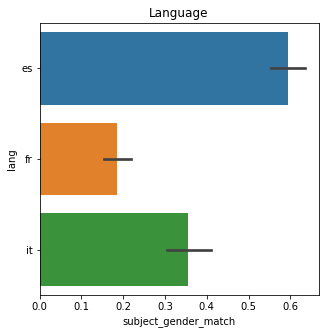

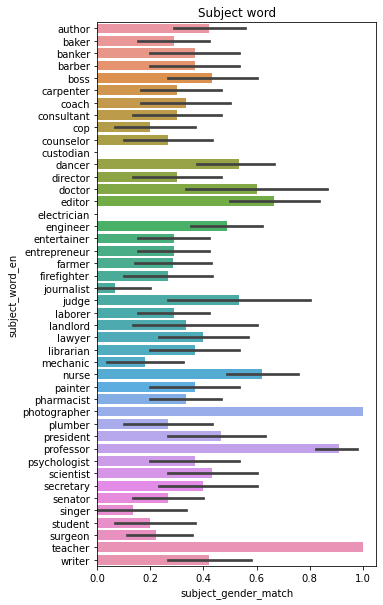

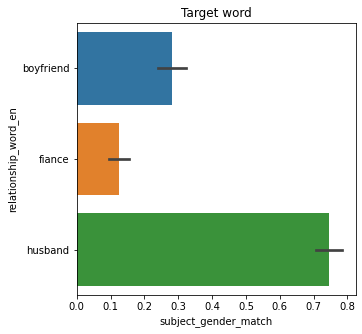

**** gender=male ****


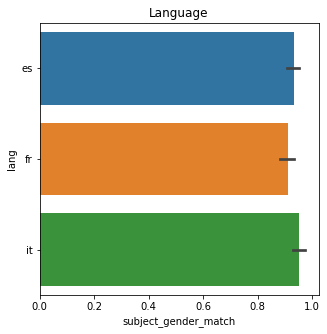

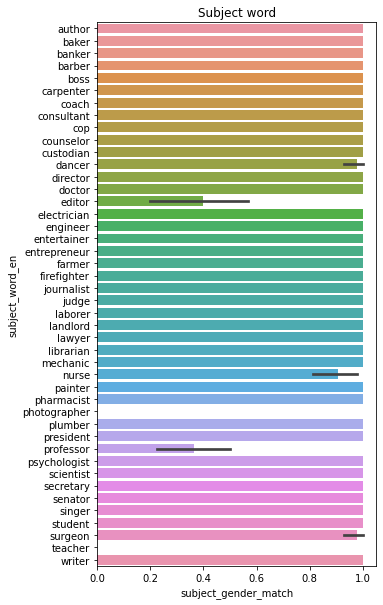

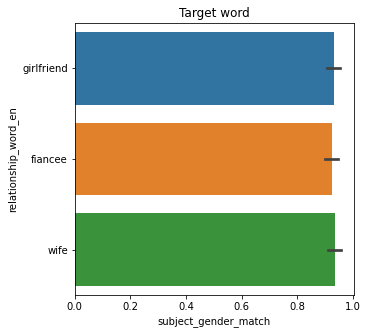

In [180]:
for gender_i, data_i in valid_diff_gender_sentence_data.groupby('subject_gender'):
    print(f'**** gender={gender_i} ****')
    ## language
    plt.figure(figsize=(5,5))
    sns.barplot(data=data_i, y='lang', x='subject_gender_match')
    plt.title('Language')
    # subject word
    plt.show()
    plt.figure(figsize=(5, 10))
    sns.barplot(data=data_i, y='subject_word_en', x='subject_gender_match', order=list(sorted(valid_final_sentence_data.loc[:, 'subject_word_en'].unique())))
    plt.title('Subject word')
    # target word
    plt.show()
    plt.figure(figsize=(5,5))
    sns.barplot(data=data_i, y='relationship_word_en', x='subject_gender_match')
    plt.title('Target word')
    plt.show()

- **Female**: the translations are generally more wrong for `female` subjects, but more correct for "typical" (?) `female` professions like `nurse`, `photographer`, `professor`, `teacher`.
- **Male**: translations are overwhelmingly correct for `male` subjects except in some occupations like `nurse`, `photographer`, `professor`, `teacher`.

### Debug: access Google Translate API directly
Borrowing code from [here](https://cloud.google.com/translate/docs/basic/translating-text#translate_translate_text-python).

In [1]:
import six
from google.cloud import translate_v2 as translate
def translate_text(target, text):
    """Translates text into the target language.

    Target must be an ISO 639-1 language code.
    See https://g.co/cloud/translate/v2/translate-reference#supported_languages
    """
    translate_client = translate.Client()

    if isinstance(text, six.binary_type):
        text = text.decode("utf-8")

    # Text can also be a sequence of strings, in which case this method
    # will return a sequence of results for each text.
    result = translate_client.translate(text, target_language=target)

    print(u"Text: {}".format(result["input"]))
    print(u"Translation: {}".format(result["translatedText"]))
    print(u"Detected source language: {}".format(result["detectedSourceLanguage"]))

In [3]:
target = 'es'
text = 'She kissed her wife'
translate_text(target, text)

DefaultCredentialsError: Could not automatically determine credentials. Please set GOOGLE_APPLICATION_CREDENTIALS or explicitly create credentials and re-run the application. For more information, please see https://cloud.google.com/docs/authentication/getting-started

We need to provide credentials, which could lead to billing. It looks like (?) the Basic service provides 300 requests total before incurring billing. This is not enough.

Actually it looks like 500K characters per month? [Here](https://cloud.google.com/translate/pricing).

In [12]:
from os import environ
environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'data/google_auth_key.json'
environ['PROJECT_ID'] = 'arcane-rigging-115120'
environ.get('PROJECT_ID')

'arcane-rigging-115120'

In [14]:
from google.cloud import translate
project_id = environ['PROJECT_ID']
parent = f'projects/{project_id}'
client = translate.TranslationServiceClient()
sample_text = 'He kissed his husband'
target_lang = 'es'
response = client.translate_text(
    contents=[sample_text],
    target_language_code=target_lang,
    parent=parent,
)
print(response)

translations {
  translated_text: "Bes\303\263 a su marido"
  detected_language_code: "en"
}



OK! This actually works. Let's try to use this from now on.

### Query translations: POSSESSIVE (Google Translate)

Same thing as before, but using the official GT API.

Keep an eye on the quotas [here](https://console.cloud.google.com/apis/api/translate.googleapis.com/overview?project=arcane-rigging-115120).

In [1]:
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import load_relationship_occupation_template_data, generate_occupation_relationship_sentence_data

In [13]:
langs

['es', 'fr', 'it', 'en']

In [14]:
from itertools import product
occupation_words, relationship_words, relationship_sents, langs, lang_art_PRON_lookup, lang_POSS_PRON_lookup = load_relationship_occupation_template_data()
langs = ['es', 'fr', 'it']
same_gender_sentence_data = generate_occupation_relationship_sentence_data(relationship_sents, 
                                                                           occupation_words, relationship_words, 
                                                                           lang_art_PRON_lookup, lang_POSS_PRON_lookup, 
                                                                           relationship_type='same_gender', langs=langs)
diff_gender_sentence_data = generate_occupation_relationship_sentence_data(relationship_sents, 
                                                                           occupation_words, relationship_words, 
                                                                           lang_art_PRON_lookup, lang_POSS_PRON_lookup, 
                                                                           relationship_type='diff_gender', langs=langs)
display(same_gender_sentence_data.head())
display(diff_gender_sentence_data.head())
# how many characters total? need to know for GT budget
total_translation_chars = same_gender_sentence_data.loc[:, 'sent'].apply(len).sum() + diff_gender_sentence_data.loc[:, 'sent'].apply(len).sum()
print(f'{total_translation_chars} chars total')

,sent,lang,subject_word,relationship_word,subject_gender,relationship_gender
0,el autor conoció a su novio en una cita.,es,autor,novio,male,male
1,el autor conoció a su prometido en una cita.,es,autor,prometido,male,male
2,el autor conoció a su esposo en una cita.,es,autor,esposo,male,male
3,el panadero conoció a su novio en una cita.,es,panadero,novio,male,male
4,el panadero conoció a su prometido en una cita.,es,panadero,prometido,male,male


,sent,lang,subject_word,relationship_word,subject_gender,relationship_gender
0,el autor conoció a su novia en una cita.,es,autor,novia,male,female
1,el autor conoció a su prometida en una cita.,es,autor,prometida,male,female
2,el autor conoció a su esposa en una cita.,es,autor,esposa,male,female
3,el panadero conoció a su novia en una cita.,es,panadero,novia,male,female
4,el panadero conoció a su prometida en una cita.,es,panadero,prometida,male,female


234504 chars total


In [15]:
from os import environ
from google.cloud import translate
def set_up_google_translate_client():
    environ['GOOGLE_APPLICATION_CREDENTIALS'] = 'data/google_auth_key.json'
    environ['PROJECT_ID'] = 'arcane-rigging-115120'
    environ.get('PROJECT_ID')
    project_id = environ['PROJECT_ID']
    parent = f'projects/{project_id}'
    client = translate.TranslationServiceClient()
    return parent, client

In [16]:
from time import sleep
def get_google_translations(text, lang, client, project_parent):
    translate_success = False
    try_ctr = 0
    max_tries = 5
    SLEEP_TIME = 30
    if(type(text) is str):
        text = [text]
    while(not translate_success and try_ctr < max_tries):
        try:
            response = client.translate_text(contents=text, target_language_code=lang, parent=project_parent)
            translate_success = True
        except Exception as e:
            print(f'translation error={e} with text={text}; sleeping for {SLEEP_TIME} sec')
            try_ctr += 1
            sleep(SLEEP_TIME)
    response_text = list(map(lambda x: x.translated_text, response._pb.translations))
    return response_text

In [17]:
sample_text = 'The baker married her wife'
target_lang = 'es'
project_parent, client = set_up_google_translate_client()
sample_response_text = get_google_translations([sample_text], target_lang, client, project_parent)
print(sample_response_text)

['El panadero se casó con su esposa']


In [9]:
from tqdm import tqdm
tqdm.pandas()
target_lang = 'en'
same_gender_translations = same_gender_sentence_data.loc[:, 'sent'].progress_apply(lambda x: get_google_translations(x, target_lang, client, project_parent))

100%|██████████| 4320/4320 [05:30<00:00, 13.06it/s]


In [10]:
diff_gender_translations = diff_gender_sentence_data.loc[:, 'sent'].progress_apply(lambda x: get_google_translations(x, target_lang, client, project_parent))

100%|██████████| 4320/4320 [05:29<00:00, 13.11it/s]


In [11]:
# post-translate data cleanup
same_gender_sentence_data = same_gender_sentence_data.assign(**{
    'translation_txt' : list(map(lambda x: x[0], same_gender_translations))
})
diff_gender_sentence_data = diff_gender_sentence_data.assign(**{
    'translation_txt' : list(map(lambda x: x[0], diff_gender_translations))
})
same_gender_sentence_data.to_csv('data/multilingual_occupation_relationship=samegender_model=googletranslate_translations.gz', compression='gzip', sep='\t', index=False)
diff_gender_sentence_data.to_csv('data/multilingual_occupation_relationship=diffgender_model=googletranslate_translations.gz', compression='gzip', sep='\t', index=False)

### Plot translation accuracy by subtype

Let's plot everything side by side for completeness.

In [2]:
## reload etc
import pandas as pd
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import load_clean_translation_data
same_gender_sentence_data_file = 'data/multilingual_occupation_relationship=samegender_model=googletranslate_translations.gz'
diff_gender_sentence_data_file = 'data/multilingual_occupation_relationship=diffgender_model=googletranslate_translations.gz'
same_gender_sentence_data = load_clean_translation_data(same_gender_sentence_data_file)
diff_gender_sentence_data = load_clean_translation_data(diff_gender_sentence_data_file)
combined_sentence_data = pd.concat([
    same_gender_sentence_data.assign(**{'relationship_type' : 'same_gender'}),
    diff_gender_sentence_data.assign(**{'relationship_type' : 'diff_gender'})
])
# same_gender_sentence_data = pd.read_csv('data/multilingual_occupation_relationship=samegender_model=googletranslate_translations.gz', compression='gzip', sep='\t')
# diff_gender_sentence_data = pd.read_csv('data/multilingual_occupation_relationship=diffgender_model=googletranslate_translations.gz', compression='gzip', sep='\t')
# same_gender_sentence_data = same_gender_sentence_data[same_gender_sentence_data.loc[:, 'lang']!='en']
# diff_gender_sentence_data = diff_gender_sentence_data[diff_gender_sentence_data.loc[:, 'lang']!='en']
# # get translation target gender etc.
# from data_helpers import load_relationship_occupation_template_data
# occupation_words, relationship_words, relationship_sents, langs, lang_art_PRON_lookup, lang_POSS_PRON_lookup = load_relationship_occupation_template_data()
# ## add subject, target genders
# from data_helpers import extract_subject_relationship_gender, translate_subject_relationship_words
# same_gender_sentence_data = extract_subject_relationship_gender(same_gender_sentence_data, relationship_words)
# same_gender_sentence_data = translate_subject_relationship_words(same_gender_sentence_data, occupation_words, relationship_words)
# diff_gender_sentence_data = extract_subject_relationship_gender(diff_gender_sentence_data, relationship_words)
# diff_gender_sentence_data = translate_subject_relationship_words(diff_gender_sentence_data, occupation_words, relationship_words)
# # fix column types?
# ## get gender-match stats
# ## same-gender data
# same_gender_sentence_data = same_gender_sentence_data.assign(**{
#     'subject_gender_match' : (same_gender_sentence_data.loc[:, 'subject_gender'] == same_gender_sentence_data.loc[:, 'translation_subject_gender']).astype(int),
#     'relationship_gender_match' : (same_gender_sentence_data.loc[:, 'subject_gender'] == same_gender_sentence_data.loc[:, 'translation_relationship_gender']).astype(int),
# })
# # limit to valid data (non-None)
# valid_same_gender_sentence_data = same_gender_sentence_data[(same_gender_sentence_data.loc[:, 'translation_subject_gender'].apply(lambda x: x is not None)) & 
#                                                             (same_gender_sentence_data.loc[:, 'translation_relationship_gender'].apply(lambda x: x is not None))]
# print(f'{valid_same_gender_sentence_data.shape[0]/same_gender_sentence_data.shape[0]} valid gender translation data for same-gender pairs')
# ## get "both match" var
# valid_same_gender_sentence_data = valid_same_gender_sentence_data.assign(**{
#     'subject_relationship_gender_match' : valid_same_gender_sentence_data.loc[:, ['relationship_gender_match', 'subject_gender_match']].min(axis=1)
# })
# ## diff-gender data
# diff_gender_sentence_data = diff_gender_sentence_data.assign(**{
#     'subject_gender_match' : (diff_gender_sentence_data.loc[:, 'subject_gender'] == diff_gender_sentence_data.loc[:, 'translation_subject_gender']).astype(int),
#     'relationship_gender_match' : (diff_gender_sentence_data.loc[:, 'relationship_gender'] == diff_gender_sentence_data.loc[:, 'translation_relationship_gender']).astype(int),
# })
# valid_diff_gender_sentence_data = diff_gender_sentence_data[(diff_gender_sentence_data.loc[:, 'translation_subject_gender'].apply(lambda x: x is not None)) & 
#                                                             (diff_gender_sentence_data.loc[:, 'translation_relationship_gender'].apply(lambda x: x is not None))]
# print(f'{valid_diff_gender_sentence_data.shape[0]/diff_gender_sentence_data.shape[0]} valid gender translation data for diff-gender pairs')
# ## combine diff + same gender data for plotting
# combined_sentence_data = pd.concat([
#     valid_same_gender_sentence_data.assign(**{'relationship_type' : 'same_gender'}),
#     valid_diff_gender_sentence_data.assign(**{'relationship_type' : 'diff_gender'}),
# ], axis=0)
# # fix categories
# relationship_target_categories = {
#     'FRIEND' : ['boyfriend', 'girlfriend'],
#     'ENGAGE' : ['fiance', 'fiancee'],
#     'SPOUSE' : ['husband', 'wife'],
# }
# relationship_target_categories = {
#     v1 : k for k, v in relationship_target_categories.items() for v1 in v
# }
# combined_sentence_data = combined_sentence_data.assign(**{
#     'relationship_word_category' : combined_sentence_data.loc[:, 'relationship_word_en'].apply(relationship_target_categories.get)
# })

bad text the ingeniero lived with his fianc2e.
bad text the farmer kissed his boy.
bad text the peasant lived with his boy.
bad text the farmer and his boy have a son.
bad text the banker kissed his bride.
bad text the carpenter kissed his bride.
bad text the farmer kissed his bride.
bad text the engineer lived with his fianc2ee.


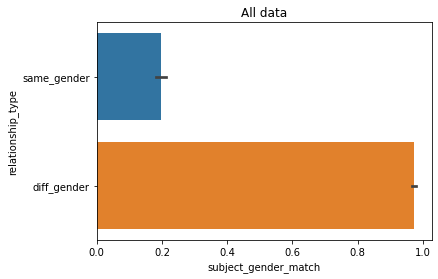

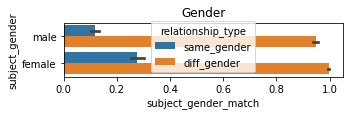

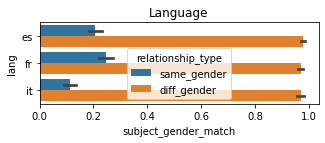

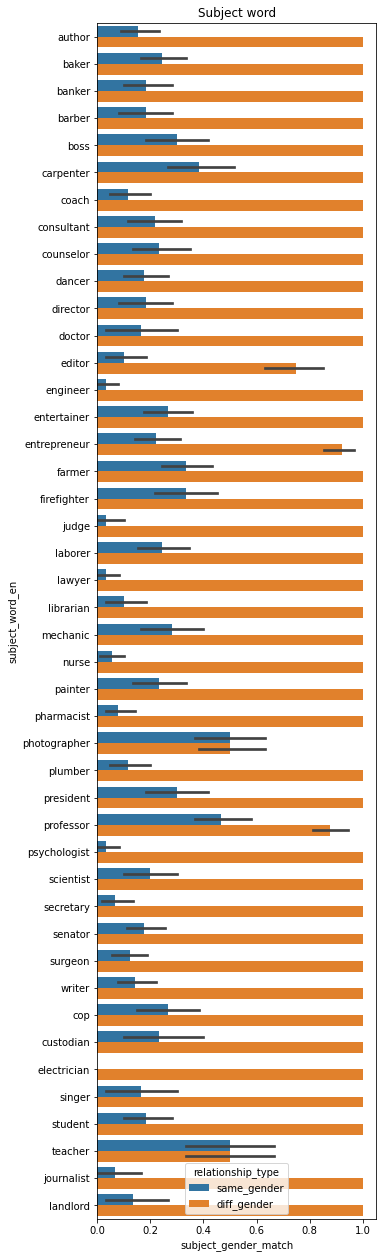

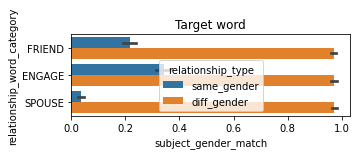

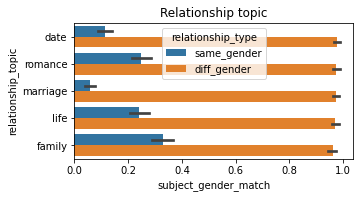

In [3]:
## show distributions 
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
def plot_scores_per_attribute(data, attr_var, title, score_var='subject_gender_match', hue_var='relationship_type'):
    width = 5
    height = data.loc[:, attr_var].nunique() * 0.5
    plt.figure(figsize=(width, height))
    sns.barplot(data=data, y=attr_var, x=score_var, hue=hue_var)
    plt.title(title)
    plt.show()
score_var = 'subject_gender_match'
## overall
sns.barplot(data=combined_sentence_data, y='relationship_type', x=score_var)
plt.title('All data')
plt.show()
attr_vars = [
    ('subject_gender','Gender'),
    ('lang', 'Language'),
    ('subject_word_en', 'Subject word'),
    ('relationship_word_category', 'Target word'),
    ('relationship_topic', 'Relationship topic'),
]
for attr_var_i, title_i in attr_vars:
    plot_scores_per_attribute(combined_sentence_data, attr_var_i, title_i, score_var=score_var)


Let's do the same thing but try to put everything on the same axis.

In [1]:
def plot_adjacent_scores(data, score_var='subject_gender_match', 
                         type_var='relationship_type', 
                         type_var_name='Relationship type',
                         plot_attr_vars=None):
    if(plot_attr_vars is None):
        plot_attr_vars = [
        ('subject_gender','Gender'),
        ('lang', 'Language'),
        ('relationship_word_category', 'Target word'),
        ('relationship_topic', 'Relationship topic'),
        ]
    N_cols = len(plot_attr_vars) + 1
    height = 4
    width = N_cols*3.
    sns.set_style('whitegrid')
    f, axs = plt.subplots(1, N_cols, figsize=(width, height))
    bar_width = 0.5
    # plot overall scores
    overall_plot = sns.barplot(data=data, x=type_var, y=score_var, ax=axs[0])
    overall_plot.set(xlabel=type_var_name)
    # plot scores per attribute
    for i, (attr_var_i, title_i) in enumerate(plot_attr_vars):
        ax_i = axs[i+1]
        width_i = data.loc[:, attr_var_i].nunique() * 1.5
        # set figure size
        sns.set(rc={'figure.figsize' : (width_i, height)})
        # rotate x ticks
        ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45)
        plot_i = sns.barplot(data=data, x=attr_var_i, y=score_var, hue=type_var, ax=ax_i)
        plot_i.set(ylabel=None, yticklabels=[], xlabel=title_i)
        if(i+1 < N_cols-1):
            plot_i.get_legend().remove()
        else:
            ax_i.legend(loc='center right')
    plt.tight_layout()
    plt.show()

<ipython-input-11-a4e5c5e43b0f>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45)
<ipython-input-11-a4e5c5e43b0f>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45)
<ipython-input-11-a4e5c5e43b0f>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45)
<ipython-input-11-a4e5c5e43b0f>:23: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45)


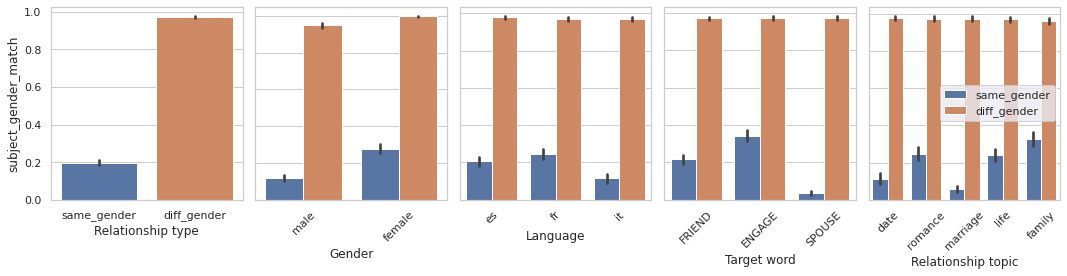

In [11]:
plot_attr_vars = [
    ('subject_gender','Gender'),
    ('lang', 'Language'),
    ('relationship_word_category', 'Target word'),
    ('relationship_topic', 'Relationship topic'),
]
N_cols = len(plot_attr_vars) + 1
height = 4
width = N_cols*3.
sns.set_style('whitegrid')
f, axs = plt.subplots(1, N_cols, figsize=(width, height))
bar_width = 0.5
# plot overall scores
overall_plot = sns.barplot(data=combined_sentence_data, x='relationship_type', y='subject_gender_match', ax=axs[0])
overall_plot.set(xlabel='Relationship type')
# plot scores per attribute
for i, (attr_var_i, title_i) in enumerate(plot_attr_vars):
    ax_i = axs[i+1]
    width_i = combined_sentence_data.loc[:, attr_var_i].nunique() * 1.5
    # set figure size
    sns.set(rc={'figure.figsize' : (width_i, height)})
    # rotate x ticks
    ax_i.set_xticklabels(ax_i.get_xticklabels(), rotation=45)
    plot_i = sns.barplot(data=combined_sentence_data, x=attr_var_i, y='subject_gender_match', hue='relationship_type', ax=ax_i)
    plot_i.set(ylabel=None, yticklabels=[], xlabel=title_i)
    if(i+1 < N_cols-1):
        plot_i.get_legend().remove()
    else:
        ax_i.legend(loc='center right')
plt.tight_layout()
plt.show()
## facet grid does not work!! different x axis for each variable
# use facet grid https://www.geeksforgeeks.org/multi-plot-grid-in-seaborn/
# flatten data because ugh
# flat_sentence_data = combined_sentence_data.melt(id_vars=['sent', 'translation_txt', 'lang', 'relationship_type', 'subject_gender_match'], 
#                                                  value_vars=plot_attr_vars,
#                                                  value_name='attr_val', var_name='attr_var')
# grid_plot = sns.FacetGrid(flat_sentence_data, col='attr_var')
# grid_plot.map(sns.barplot, 'attr_val', 'subject_gender_match')
# plt.show()

# display(flat_sentence_data.head())

### Translation error analysis: occupation metadata
Let's look at some metadata for the different occupations and see if that predicts translation bias. 

- income level (lower income ~ less barrier to entry ~ less bias)
- female representation (gender equality ~ less bias)
- age (younger ~ less bias)

We'll do this as a typical regression, w/ controls for language, relationship type, etc.

In [52]:
## get occupation data + categories
import pandas as pd
occupation_data = pd.read_csv('data/multilingual_gender_occupations.tsv', sep='\t')
occupation_category_data = pd.read_csv('data/metadata/occupation_categories.tsv', sep='\t')
# convert categories => list
category_vars = list(filter(lambda x: x.startswith('categories_'), occupation_category_data.columns))
occupation_category_data = occupation_category_data.assign(**{
    var_i : occupation_category_data.loc[:, var_i].apply(lambda x: x.split(';') if type(x) is str else [])
    for var_i in category_vars
})
## get other metadata
age_occupation_data = pd.read_csv('data/metadata/age_occupation_data.tsv', sep='\t')
income_gender_occupation_data = pd.read_csv('data/metadata/female_work_representation_data.tsv', sep='\t')
# fix column names
age_occupation_data.rename(columns={'Median\n age' : 'median_age', 'Total, 16\nyears and\n over' : 'total_pop'}, inplace=True)
income_gender_occupation_data.rename(columns={'Median earnings' : 'median_earnings', 'Percentage of women in occupational group' : 'women_pct', 'Number of full-time workers' : 'total_pop'}, inplace=True)
# remove occupation w/ insufficient data
age_occupation_data = age_occupation_data[age_occupation_data.loc[:, 'median_age']!='–']
# fix numbers
number_vars = ['median_earnings', 'total_pop', 'median_age']
for number_var_i in number_vars:
    if(number_var_i in income_gender_occupation_data.columns):
        income_gender_occupation_data = income_gender_occupation_data.assign(**{
            number_var_i : income_gender_occupation_data.loc[:, number_var_i].apply(lambda x: x.replace(',','')  if type(x) is str else x).astype(float)
        })
    if(number_var_i in age_occupation_data.columns):
        age_occupation_data = age_occupation_data.assign(**{
            number_var_i : age_occupation_data.loc[:, number_var_i].apply(lambda x: x.replace(',','') if type(x) is str else x).astype(float)
        })
display(age_occupation_data.head())
display(income_gender_occupation_data.head())

,Occupation,total_pop,16 to 19 \nyears,20 to 24 \nyears,25 to 34 \nyears,35 to 44 \nyears,45 to 54 \nyears,55 to 64 \nyears,65 years\nand over,median_age
0,Total employed,152581.0,"5,266","13,409","34,578","32,734","30,554","25,912","10,127",42.2
1,"Management, professional, and related occupat...",64744.0,420,"3,267","15,222","15,625","14,238","11,394","4,579",43.8
2,"Management, business, and financial operations...",27864.0,100,"1,052","5,726","6,783","6,603","5,411","2,189",45.5
3,Management occupations,18986.0,74,573,"3,413","4,728","4,704","3,863","1,630",46.5
4,Chief executives,1664.0,1,4,157,388,446,464,204,51.6


,Occupation,total_pop,Number of men,Number of women,women_pct,median_earnings,Median earnings men,Median earnings women,Women's earnings as a percentage of men's earnings
0,Accountants and auditors,1442414.0,"596,824","845,590",58.6,70258.0,"80,288","64,303",80.1
1,Actuaries,30007.0,"18,798","11,209",37.4,121833.0,"133,788","101,006",75.5
2,Administrative services managers,56637.0,"17,489","39,148",69.1,64213.0,"76,445","60,398",79.0
3,Advertising and promotions managers,47962.0,"20,939","27,023",56.3,81019.0,"91,634","72,041",78.6
4,Advertising sales agents,103843.0,"48,747","55,096",53.1,67930.0,"75,437","61,978",82.2


In [36]:
import numpy as np
def get_mean_attribute_per_occupation(attr, occupation_categories, occupation_data, pop_var='total_pop', occupation_var='Occupation'):
    ## get weighted mean of attribute per occupation
    ## ex. if "artist" has 2 categories, compute X% * attr_X + Y% * attr_Y
    category_match_occupation_data = occupation_data[occupation_data.loc[:, occupation_var].isin(occupation_categories)]
    attr_per_pop = np.nan
    if(category_match_occupation_data.shape[0] > 0):
        attr_per_pop = (category_match_occupation_data.loc[:, pop_var] * category_match_occupation_data.loc[:, attr]).sum() / category_match_occupation_data.loc[:, pop_var].sum()
    return attr_per_pop

In [103]:
# income
income_attr = 'median_earnings'
occupation_category_data = occupation_category_data.assign(**{
    'income' : occupation_category_data.loc[:, 'categories_BOLS'].apply(lambda x: get_mean_attribute_per_occupation(income_attr, x, income_gender_occupation_data))
})
# gender
gender_attr = 'women_pct'
occupation_category_data = occupation_category_data.assign(**{
    'women_pct' : occupation_category_data.loc[:, 'categories_BOLS'].apply(lambda x: get_mean_attribute_per_occupation(gender_attr, x, income_gender_occupation_data))
})
# age
age_attr = 'median_age'
occupation_category_data = occupation_category_data.assign(**{
    'age' : occupation_category_data.loc[:, 'categories_DOL'].apply(lambda x: get_mean_attribute_per_occupation(age_attr, x, age_occupation_data))
})
# Z-norm everything for regression!!
from sklearn.preprocessing import StandardScaler
occupation_social_vars = ['income', 'women_pct', 'age']
for var_i in occupation_social_vars:
    scaler = StandardScaler()
    vals_i = scaler.fit_transform(occupation_category_data.loc[:, var_i].values.reshape(-1,1))
    occupation_category_data = occupation_category_data.assign(**{
        var_i : vals_i
    })

In [104]:
display(occupation_category_data.head())

,occupation,categories_BOLS,categories_DOL,income,women_pct,age
0,analyst,"[Management analysts, Budget analysts, Credit ...","[Budget analysts, Computer systems analysts, C...",0.748566,0.003007,-0.231182
1,artist,[Artists and related workers],[Artists and related workers],-0.534250,-0.108669,0.037273
2,athlete,[Athletes and sports competitors],[],NaN,NaN,NaN
3,author,[Writers and authors],[Writers and authors],-0.097949,0.560002,0.313425
4,baker,[Bakers],[Bakers],-1.244527,0.633440,-0.257288


Let's look at the extreme occupations for all attributes.

In [105]:
attrs = ['income', 'women_pct', 'age']
for attr_i in attrs:
    print(f'attr = {attr_i}')
    data_i = occupation_category_data.loc[:, ['occupation', attr_i]].dropna(subset=[attr_i]).sort_values(attr_i, ascending=False)
    display(data_i.head(5))
    data_i.sort_values(attr_i, ascending=True, inplace=True)
    display(data_i.head(5))

attr = income


,occupation,income
15,dentist,3.169521
29,lawyer,2.425472
35,pharmacist,2.101467
26,judge,1.488126
20,engineer,1.071080


,occupation,income
32,nanny,-1.466213
4,baker,-1.244527
6,barber,-1.243020
27,laborer,-1.079119
34,painter,-1.074988


attr = women_pct


,occupation,women_pct
32,nanny,2.075141
43,secretary,2.048244
33,nurse,1.765929
30,librarian,1.576537
48,teacher,1.323772


,occupation,women_pct
37,plumber,-1.531043
19,electrician,-1.515583
8,carpenter,-1.511718
31,mechanic,-1.507853
24,firefighter,-1.449875


attr = age


,occupation,age
23,farmer,2.375356
26,judge,1.841463
30,librarian,1.252340
39,professor,1.160289
41,realtor,1.105059


,occupation,age
21,entertainer,-3.552696
9,coach,-1.564405
25,journalist,-1.509175
27,laborer,-1.490765
32,nanny,-0.993692


Reload the translation results, compute error rate.

In [60]:
from data_helpers import load_clean_translation_data
same_gender_relationship_translation_data_file = 'data/multilingual_occupation_relationship=samegender_model=googletranslate_translations.gz'
diff_gender_relationship_translation_data_file = 'data/multilingual_occupation_relationship=diffgender_model=googletranslate_translations.gz'
same_gender_relationship_translation_data = load_clean_translation_data(same_gender_relationship_translation_data_file)
diff_gender_relationship_translation_data = load_clean_translation_data(diff_gender_relationship_translation_data_file)

bad text the ingeniero lived with his fianc2e.
bad text the farmer kissed his boy.
bad text the peasant lived with his boy.
bad text the farmer and his boy have a son.
bad text the banker kissed his bride.
bad text the carpenter kissed his bride.
bad text the farmer kissed his bride.
bad text the engineer lived with his fianc2ee.


In [106]:
# compute % correct per-occupation per-language
same_gender_per_occupation_subject_match_pct = same_gender_relationship_translation_data.groupby(['lang', 'subject_gender', 'relationship_word_category', 'subject_word_en']).apply(lambda x: x.loc[:, 'subject_gender_match'].mean())
diff_gender_per_occupation_subject_match_pct = diff_gender_relationship_translation_data.groupby(['lang', 'subject_gender', 'relationship_word_category', 'subject_word_en']).apply(lambda x: x.loc[:, 'subject_gender_match'].mean())
same_vs_diff_gender_per_occupation_subject_match_pct = (diff_gender_per_occupation_subject_match_pct - same_gender_per_occupation_subject_match_pct)  
same_vs_diff_gender_per_occupation_subject_match_pct = same_vs_diff_gender_per_occupation_subject_match_pct.reset_index(name='diff_gender_same_gender_match_diff')
display(same_vs_diff_gender_per_occupation_subject_match_pct.head())
# add occupation data
occupation_match_pct_data = pd.merge(
    same_vs_diff_gender_per_occupation_subject_match_pct.rename(columns={'subject_word_en' : 'occupation'}), 
    occupation_category_data, on='occupation'
)
occupation_social_vars = ['income', 'women_pct', 'age']
occupation_match_pct_data.dropna(subset=occupation_social_vars, how='any', inplace=True)
display(occupation_match_pct_data)
print(occupation_match_pct_data.shape[0])

,lang,subject_gender,relationship_word_category,subject_word_en,diff_gender_same_gender_match_diff
0,es,female,ENGAGE,author,0.6
1,es,female,ENGAGE,baker,0.6
2,es,female,ENGAGE,banker,1.0
3,es,female,ENGAGE,barber,0.6
4,es,female,ENGAGE,boss,0.6


,lang,subject_gender,relationship_word_category,occupation,diff_gender_same_gender_match_diff,categories_BOLS,categories_DOL,income,women_pct,age
0,es,female,ENGAGE,author,0.6,[Writers and authors],[Writers and authors],-0.097949,0.560002,0.313425
1,es,female,FRIEND,author,0.6,[Writers and authors],[Writers and authors],-0.097949,0.560002,0.313425
2,es,female,SPOUSE,author,1.0,[Writers and authors],[Writers and authors],-0.097949,0.560002,0.313425
3,es,male,ENGAGE,author,0.6,[Writers and authors],[Writers and authors],-0.097949,0.560002,0.313425
4,es,male,FRIEND,author,0.8,[Writers and authors],[Writers and authors],-0.097949,0.560002,0.313425
...,...,...,...,...,...,...,...,...,...,...
559,it,female,FRIEND,landlord,0.8,"[Property, real estate, and community associat...","[Property, real estate, and community associat...",-0.281987,0.440183,1.031419
560,it,female,SPOUSE,landlord,1.0,"[Property, real estate, and community associat...","[Property, real estate, and community associat...",-0.281987,0.440183,1.031419
561,it,male,ENGAGE,landlord,1.0,"[Property, real estate, and community associat...","[Property, real estate, and community associat...",-0.281987,0.440183,1.031419
562,it,male,FRIEND,landlord,0.8,"[Property, real estate, and community associat...","[Property, real estate, and community associat...",-0.281987,0.440183,1.031419


426


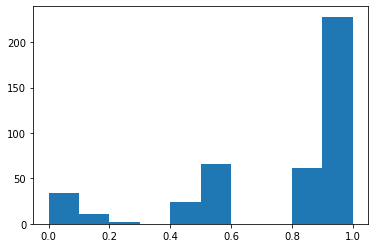

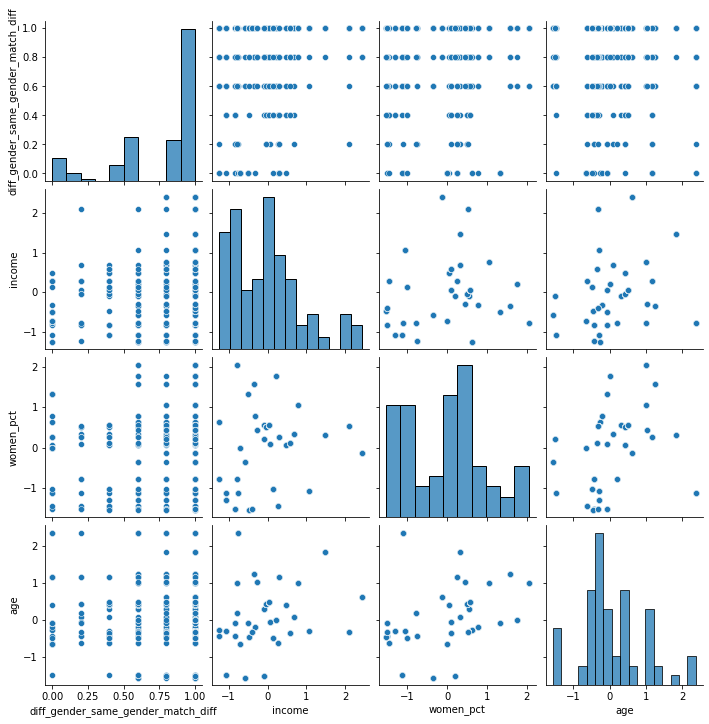

diff_gender_same_gender_match_diff vs. income has correl=0.191 (p=7.377E-05)
diff_gender_same_gender_match_diff vs. women_pct has correl=0.107 (p=2.780E-02)
diff_gender_same_gender_match_diff vs. age has correl=0.044 (p=3.668E-01)
income vs. women_pct has correl=0.223 (p=3.254E-06)
income vs. age has correl=0.238 (p=6.477E-07)
women_pct vs. age has correl=0.471 (p=5.931E-25)


In [107]:
## check distribution of dependent var
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.hist(occupation_match_pct_data.loc[:, 'diff_gender_same_gender_match_diff'])
plt.show()
## check possible correlations
import seaborn as sns
correl_vars = ['diff_gender_same_gender_match_diff', 'income', 'women_pct', 'age']
sns.pairplot(data=occupation_match_pct_data.loc[:, correl_vars])
plt.show()
from scipy.stats import spearmanr
for i, var_i in enumerate(correl_vars):
    for var_j in correl_vars[(i+1):]:
        correl, p_val = spearmanr(occupation_match_pct_data.loc[:, var_i], occupation_match_pct_data.loc[:, var_j])
        print(f'{var_i} vs. {var_j} has correl={correl:.3f} (p={p_val:.3E})')

- Higher-income occupations have more diff vs. same gender difference (more conservative expectations for high income occupations?)
- Occupations w/ higher female participation have more diff vs. same gender difference (stronger gender norms?)

In [108]:
from statsmodels.api import OLS
dep_var = 'diff_gender_same_gender_match_diff'
cat_vars = ['lang', 'subject_gender', 'relationship_word_category']
cat_var_str = ' + '.join(list(map(lambda x: f'C({x})', cat_vars)))
scalar_vars = ['income', 'women_pct', 'age']
scalar_var_str = ' + '.join(scalar_vars)
formula = f'{dep_var} ~ {cat_var_str} + {scalar_var_str}'
model = OLS.from_formula(formula, data=occupation_match_pct_data)
reg_results = model.fit()9
reg_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                    
==============================================================================================
Dep. Variable:     diff_gender_same_gender_match_diff   R-squared:                       0.226
Model:                                            OLS   Adj. R-squared:                  0.211
Method:                                 Least Squares   F-statistic:                     15.23
Date:                                Mon, 21 Feb 2022   Prob (F-statistic):           1.17e-19
Time:                                        00:14:34   Log-Likelihood:                -54.827
No. Observations:                                 426   AIC:                             127.7
Df Residuals:                                     417   BIC:                             164.1
Df Model:                                           8                                         
Covariance Type:                            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                   0.5983      0.032     18.824      0.000       0.536       0.661
C(lang)[T.fr]                              -0.0501      0.031     -1.594      0.112      -0.112       0.012
C(lang)[T.it]                               0.0686      0.035      1.986      0.048       0.001       0.136
C(subject_gender)[T.male]                   0.0911      0.027      3.379      0.001       0.038       0.144
C(relationship_word_category)[T.FRIEND]     0.1127      0.033      3.413      0.001       0.048       0.178
C(relationship_word_category)[T.SPOUSE]     0.2831      0.033      8.576      0.000       0.218       0.348
income                                      0.0751      0.015      4.879      0.000       0.045       0.105
women_pct                                   0.0029      0.014      0.202      0.840      -0.026       0.031
age                                        -0.0166      0.016     -1.006      0.315      -0.049       0.016
==============================================================================
Omnibus:                       99.622   Durbin-Watson:                   1.091
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              180.328
Skew:                          -1.331   Prob(JB):                     6.96e-40
Kurtosis:                       4.753   Cond. No.                         4.79
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

- `lang=IT`: (+)
- `subject_gender=male`: (+)
- `relationship=FRIEND`: (+)
- `relationship=SPOUSE`: (+)
- `income`: (+)

The effects from the language variables are replicating what we saw before, and we see a positive correlation with income (higher income jobs are less equitable?).

Let's treat this as a logistic regression, w/ the dependent variable as "subject gender match".

In [109]:
relationship_translation_data = pd.concat([
    same_gender_relationship_translation_data.assign(**{'relationship_type' : 'same_gender'}),
    diff_gender_relationship_translation_data.assign(**{'relationship_type' : 'diff_gender'}),
])
occupation_social_vars = ['income', 'women_pct', 'age']
relationship_translation_data = pd.merge(
    relationship_translation_data.rename(columns={'subject_word_en' : 'occupation'}),
    occupation_category_data.loc[:, ['occupation'] + occupation_social_vars].dropna(subset=occupation_social_vars, how='any'), on='occupation',
)
print(relationship_translation_data.shape[0])
display(relationship_translation_data.head())

4260


,sent,lang,subject_word,relationship_word,subject_gender,relationship_gender,translation_txt,translation_subject_gender,translation_relationship_gender,occupation,relationship_word_en,subject_gender_match,relationship_gender_match,subject_relationship_gender_match,relationship_word_category,relationship_type,income,women_pct,age
0,el autor conoció a su novio en una cita.,es,autor,novio,male,male,the author met her boyfriend on a date.,female,male,author,boyfriend,0,1,0,FRIEND,same_gender,-0.097949,0.560002,0.313425
1,el autor conoció a su prometido en una cita.,es,autor,prometido,male,male,the author met her fiancé on a date.,female,male,author,fiance,0,1,0,ENGAGE,same_gender,-0.097949,0.560002,0.313425
2,el autor conoció a su esposo en una cita.,es,autor,esposo,male,male,the author met her husband on a date.,female,male,author,husband,0,1,0,SPOUSE,same_gender,-0.097949,0.560002,0.313425
3,la autora conoció a su novia en una cita.,es,autora,novia,female,female,the author met his girlfriend on a date.,male,female,author,girlfriend,0,1,0,FRIEND,same_gender,-0.097949,0.560002,0.313425
4,la autora conoció a su prometida en una cita.,es,autora,prometida,female,female,the author met his fiancée on a date.,male,female,author,fiancee,0,1,0,ENGAGE,same_gender,-0.097949,0.560002,0.313425


In [122]:
from statsmodels.api import Logit
# run regression separately for each relationship type
dep_var = 'subject_gender_match'
cat_vars = ['lang', 'subject_gender', 'relationship_word_category']
# cat_vars = ['subject_gender']
cat_var_str = ' + '.join(list(map(lambda x: f'C({x})', cat_vars)))
scalar_vars = ['income', 'women_pct', 'age']
scalar_var_str = ' + '.join(scalar_vars)
formula = f'{dep_var} ~ {cat_var_str} + {scalar_var_str}'
for relationship_type_i, data_i in relationship_translation_data.groupby('relationship_type'):
    print(f'relationship type = {relationship_type_i}')
    try:
        model = Logit.from_formula(formula, data=data_i)
        reg_results = model.fit()
        display(reg_results.summary())
    except Exception as e:
        pass

relationship type = diff_gender
Optimization terminated successfully.
         Current function value: 0.111769
         Iterations 23
relationship type = same_gender
Optimization terminated successfully.
         Current function value: 0.400806
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Logit Regression Results                            
================================================================================
Dep. Variable:     subject_gender_match   No. Observations:                 2130
Model:                            Logit   Df Residuals:                     2121
Method:                             MLE   Df Model:                            8
Date:                  Mon, 21 Feb 2022   Pseudo R-squ.:                  0.1884
Time:                          00:22:59   Log-Likelihood:                -853.72
converged:                         True   LL-Null:                       -1051.8
Covariance Type:              nonrobust   LLR p-value:                 1.182e-80
===========================================================================================================
                                              coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  -0.2106      0.124     -1.694      0.090      -0.454       0.033
C(lang)[T.fr]                               0.2390      0.136      1.754      0.079      -0.028       0.506
C(lang)[T.it]                              -0.5332      0.167     -3.195      0.001      -0.860      -0.206
C(subject_gender)[T.male]                  -1.2182      0.127     -9.581      0.000      -1.467      -0.969
C(relationship_word_category)[T.FRIEND]    -0.6489      0.129     -5.025      0.000      -0.902      -0.396
C(relationship_word_category)[T.SPOUSE]    -2.5935      0.210    -12.373      0.000      -3.004      -2.183
income                                     -0.4880      0.079     -6.200      0.000      -0.642      -0.334
women_pct                                  -0.1731      0.064     -2.718      0.007      -0.298      -0.048
age                                         0.1852      0.070      2.628      0.009       0.047       0.323
===========================================================================================================
"""

Now we see consistent social effects! Remember the interpretation is the opposite of above, i.e. negative correlation => no subject gender match.

For same-gender relationships only:
- `income`: (-) higher income means less subject gender match for SG relationships
- `women_pct` (-): more female representation (e.g. `occupation=nanny`) means less subject gender match for SG relationships, because more conservative social expectations (?)
- `age`: (+) "older" occupations (`occupation=judge`) means more subject gender match for SG relationships, because "younger" professions (`occupation=entertainer`) have arbitrary/difficult/public-facing standards for young people to adhere to (?)

Let's do the same thing but set dependent variable = 1 if different gender right and same gender wrong, 0 if both different gender and same gender right.

### Query translations: NULL_SUBJECT
In which we test the tendency of the translation model to insert a different-gender pronoun for sentences with `NULL_SUBJECT`, e.g. P("he was married to his wife") > P("she was married to her wife").

NOTE: French is not pro-drop; Italian/Portuguese/Spanish are pro-drop

In [1]:
from googletrans import Translator
translator = Translator()
test_query = "Besó a su esposo."
test_query_trans = translator.translate(test_query, dest='en', src='es')
print(test_query_trans)

Translated(src=es, dest=en, text=He kissed her husband., pronunciation=None, extra_data="{'confiden...")


### Query translations: ambiguous relationship targets
In which we test the tendency of the translation model to assume a particular gender for ambiguous relationship targets, e.g. P("su esposo" | "his spouse") < P("su esposa" | "his spouse").

Ambiguous terms: "spouse", "partner", "companion".

NOTE: we may need to compute the actual conditional probabilities rather than decoding; use [this](https://opennmt.net/)

In [22]:
from googletrans import Translator
translator = Translator()
test_query = "She married her partner last year."
test_query_trans = translator.translate(test_query, dest='it', src='en')
print(test_query_trans)

Translated(src=en, dest=it, text=Ha sposato il suo compagno l'anno scorso., pronunciation=None, extra_data="{'confiden...")


### Query translations: relationship biases in occupations and names
Let's go back to the original relationship-target translation task, but replace the occupations with names.

Can we identify consistently "same-gender" associated names? E.g. is "Juan" more likely to have a same-gender relationship correctly translated than "Diego"? Is there any correlation between a name's prototypical gender association (e.g. $\texttt{cosine(NAME, "he")}$) and their likelihood of being "allowed" to have a same-gender relationship?

Let's also do this comparison for the same occupations that we used before, and compare the same-gender error rate with how "gendered" the occupation word appears to  be.

### Query translations: relationships with unambiguous gender words
One possible explanation for the bias in the occupation-related words is that these occupation words have uncertain gender associations compared to more clear-cut words: e.g. "el doctor" could plausibly refer to a female or male doctor if a speaker has a generous interpretation.

Let's back-off from the occupation word lists to more common, unambiguously gendered words:
- man/woman
- guy/gal (this pair could be hard depending on the language)
- father/mother (e.g. "my father")
- brother/sister
- son/daughter
- uncle/aunt
- grandfather/grandmother
- gay man/lesbian

## Old code

In [1]:
## reload data
import pandas as pd
same_gender_sentence_data = pd.read_csv('data/multilingual_occupation_relationship=samegender_model=googletranslate_translations.gz', compression='gzip', sep='\t')
diff_gender_sentence_data = pd.read_csv('data/multilingual_occupation_relationship=diffgender_model=googletranslate_translations.gz', compression='gzip', sep='\t')

In [2]:
## tmp debugging: need to re-add relationship topic to translation data
def get_relationship_topic(sentence, relationship_topic_lookup):
    for topic_i, sent_matcher_i in relationship_topic_lookup:
        if(sent_matcher_i.match(sentence) is not None):
            return topic_i
    return ''

relationship_data = pd.read_csv('data/multilingual_relationship_sentences.tsv', sep='\t')

In [3]:
import re
langs = ['en', 'es', 'fr', 'it']
relationship_topics = relationship_data.loc[:, 'topic'].values
lang_relationship_topic_lookup = {
    l : list(zip(relationship_data.loc[:, f'{l}_sentence'].values, relationship_topics))
    for l in langs
}
# for each lang, get list of (relationship_topic, topic_matcher)
lang_relationship_topic_lookup = {
    k : [(v1, re.compile(re.sub('([XY]|PRON)', '.*', k1).strip())) for k1, v1 in v]
    for k,v in lang_relationship_topic_lookup.items()
}
same_gender_sentence_data = same_gender_sentence_data.assign(**{
    'relationship_topic' : same_gender_sentence_data.apply(lambda x: get_relationship_topic(x.loc['sent'], lang_relationship_topic_lookup[x.loc['lang']]), axis=1)
})
diff_gender_sentence_data = diff_gender_sentence_data.assign(**{
    'relationship_topic' : diff_gender_sentence_data.apply(lambda x: get_relationship_topic(x.loc['sent'], lang_relationship_topic_lookup[x.loc['lang']]), axis=1)
})

In [4]:
same_gender_sentence_data = same_gender_sentence_data[same_gender_sentence_data.loc[:, 'lang']!='en']
diff_gender_sentence_data = diff_gender_sentence_data[diff_gender_sentence_data.loc[:, 'lang']!='en']

In [5]:
## add subject, target genders
from importlib import reload
import data_helpers
reload(data_helpers)
from data_helpers import load_relationship_occupation_template_data, extract_subject_relationship_gender, translate_subject_relationship_words
occupation_words, relationship_words, relationship_sents, langs, lang_art_PRON_lookup, lang_POSS_PRON_lookup = load_relationship_occupation_template_data()
same_gender_sentence_data = extract_subject_relationship_gender(same_gender_sentence_data, relationship_words)
same_gender_sentence_data = translate_subject_relationship_words(same_gender_sentence_data, occupation_words, relationship_words)
diff_gender_sentence_data = extract_subject_relationship_gender(diff_gender_sentence_data, relationship_words)
diff_gender_sentence_data = translate_subject_relationship_words(diff_gender_sentence_data, occupation_words, relationship_words)

bad text the ingeniero lived with his fianc2e.
bad text the farmer kissed his boy.
bad text the peasant lived with his boy.
bad text the farmer and his boy have a son.
bad text the banker kissed his bride.
bad text the carpenter kissed his bride.
bad text the farmer kissed his bride.
bad text the engineer lived with his fianc2ee.


In [6]:
## get gender-match stats
## same-gender data
same_gender_sentence_data = same_gender_sentence_data.assign(**{
    'subject_gender_match' : (same_gender_sentence_data.loc[:, 'subject_gender'] == same_gender_sentence_data.loc[:, 'translation_subject_gender']).astype(int),
    'relationship_gender_match' : (same_gender_sentence_data.loc[:, 'subject_gender'] == same_gender_sentence_data.loc[:, 'translation_relationship_gender']).astype(int),
})
# limit to valid data (non-None)
valid_same_gender_sentence_data = same_gender_sentence_data[(same_gender_sentence_data.loc[:, 'translation_subject_gender'].apply(lambda x: x is not None)) & 
                                                            (same_gender_sentence_data.loc[:, 'translation_relationship_gender'].apply(lambda x: x is not None))]
print(f'{valid_same_gender_sentence_data.shape[0]/same_gender_sentence_data.shape[0]} valid gender translation data for same-gender pairs')
## get "both match" var
valid_same_gender_sentence_data = valid_same_gender_sentence_data.assign(**{
    'subject_relationship_gender_match' : valid_same_gender_sentence_data.loc[:, ['relationship_gender_match', 'subject_gender_match']].min(axis=1)
})
## diff-gender data
diff_gender_sentence_data = diff_gender_sentence_data.assign(**{
    'subject_gender_match' : (diff_gender_sentence_data.loc[:, 'subject_gender'] == diff_gender_sentence_data.loc[:, 'translation_subject_gender']).astype(int),
    'relationship_gender_match' : (diff_gender_sentence_data.loc[:, 'relationship_gender'] == diff_gender_sentence_data.loc[:, 'translation_relationship_gender']).astype(int),
})
valid_diff_gender_sentence_data = diff_gender_sentence_data[(diff_gender_sentence_data.loc[:, 'translation_subject_gender'].apply(lambda x: x is not None)) & 
                                                            (diff_gender_sentence_data.loc[:, 'translation_relationship_gender'].apply(lambda x: x is not None))]
print(f'{valid_diff_gender_sentence_data.shape[0]/diff_gender_sentence_data.shape[0]} valid gender translation data for diff-gender pairs')

0.9985815602836879 valid gender translation data for same-gender pairs
0.9985815602836879 valid gender translation data for diff-gender pairs


Are there any disparities in subject gender matching for same-gender vs. diff-gender pairs?

In [7]:
print(valid_same_gender_sentence_data.loc[:, 'subject_gender_match'].mean()*100)
print(valid_same_gender_sentence_data.loc[:, 'relationship_gender_match'].mean()*100)
print(valid_diff_gender_sentence_data.loc[:, 'subject_gender_match'].mean()*100)
print(valid_diff_gender_sentence_data.loc[:, 'relationship_gender_match'].mean()*100)

19.63778409090909
100.0
97.23011363636364
100.0


OK! Massive discrepancy here. Let's see the breakdown by gender etc.

In [9]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
def plot_match_rates(data, data_title):
    ## show distributions 
    ## plot on same chart!!
    ## gender
    plt.figure(figsize=(5,5))
    sns.barplot(data=data, y='subject_gender', x='subject_gender_match')
    plt.title(f'Gender (data={data_title})')
    ## language
    plt.figure(figsize=(5,5))
    sns.barplot(data=data, y='lang', x='subject_gender_match')
    plt.title(f'Language (data={data_title})')
    # subject word
    subject_word_order = order=list(sorted(data.loc[:, 'subject_word_en'].unique()))
    plt.show()
    plt.figure(figsize=(5, 10))
    sns.barplot(data=data, y='subject_word_en', x='subject_gender_match', hue_order=subject_word_order)
    plt.title(f'Subject word (data={data_title})')
    # target word
    plt.show()
    plt.figure(figsize=(5,5))
    sns.barplot(data=data, y='relationship_word_en', x='subject_gender_match')
    plt.title(f'Target word (data={data_title})')
    plt.show()

**** same-gender sentences ****


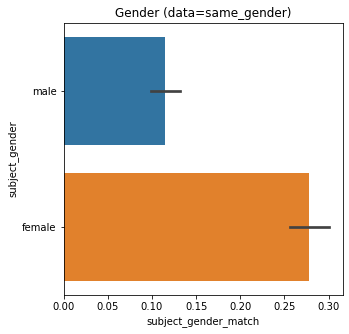

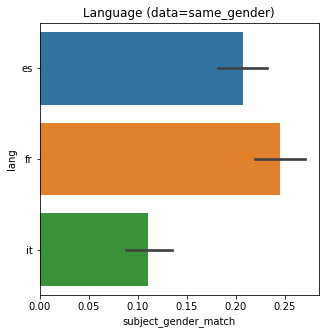

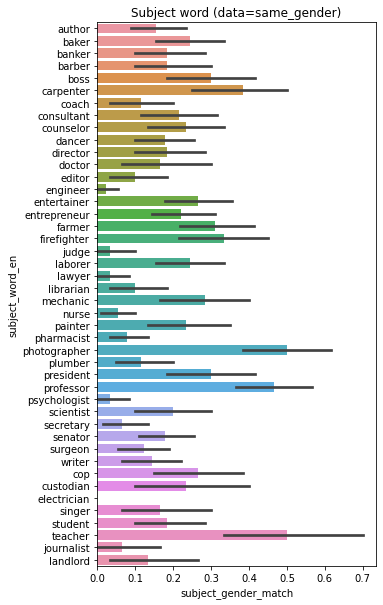

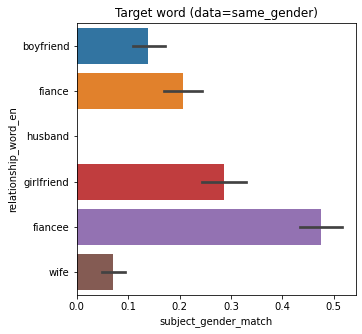

**** diff-gender sentences ****


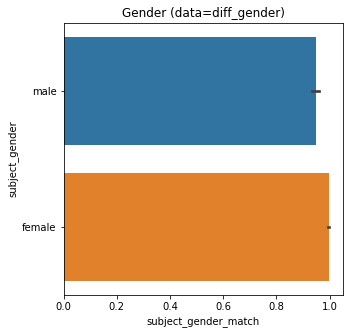

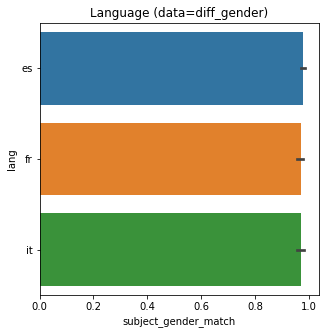

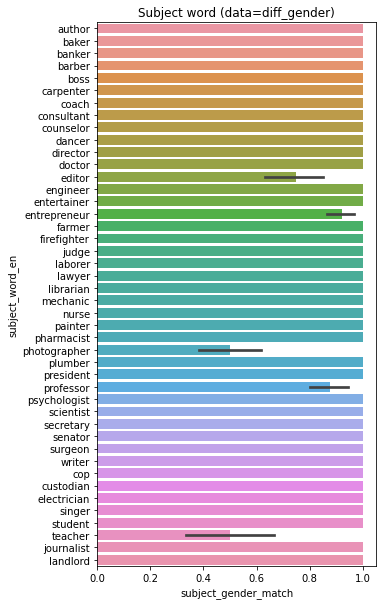

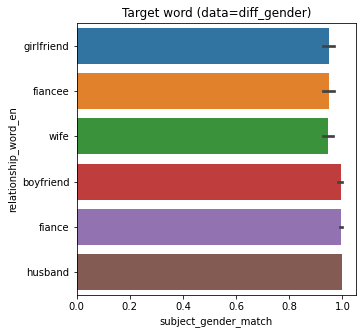

In [10]:
print('**** same-gender sentences ****')
plot_match_rates(valid_same_gender_sentence_data, 'same_gender')
print('**** diff-gender sentences ****')
plot_match_rates(valid_diff_gender_sentence_data, 'diff_gender')